In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import scipy

In [2]:
pyna_settings = pyna.load_settings(case_name='a10')
pyna_settings.ac_name = 'a10'
py = pyna(settings = pyna_settings)
py.ac.load_aerodynamics(settings=py.settings)

In [3]:
# Create aerodynamics cubic interpolants 
A  = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
TF = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
TS = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
CL = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
CD = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))

cntr = -1
for i, a in enumerate(py.ac.aero['alpha']):
    for j, tf in enumerate(py.ac.aero['theta_flaps']):
        for k, ts in enumerate(py.ac.aero['theta_slats']):
            cntr = cntr + 1
            A[cntr] = a
            TF[cntr] = tf
            TS[cntr] = ts
            CL[cntr] = py.ac.aero['c_l'][i,j,k]
            CD[cntr] = py.ac.aero['c_d'][i,j,k]
            
f_LD = scipy.interpolate.Rbf(A, TF, TS, CL/CD, function='linear')

f_alpha = scipy.interpolate.Rbf(TS, TF, CL, A, function='linear')

In [4]:
alpha_lst  = np.linspace(0, 25, 100)
theta_best = np.zeros(100)
cl_theta_best = np.zeros(100)
V_min = np.zeros(100)

for i, alpha in enumerate(alpha_lst):

    theta_lst = np.linspace(0, 26, 100)
    
    LD_lst = f_LD(alpha*np.ones(np.size(theta_lst)), theta_lst, -6*np.ones(np.size(theta_lst)))
    theta_best[i] = theta_lst[np.where(LD_lst == np.max(LD_lst))]    

    V_min[i] = np.sqrt(2 * 9.81*55000 / 1.183858 / 150.4 / cl_theta_best[i])
    

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


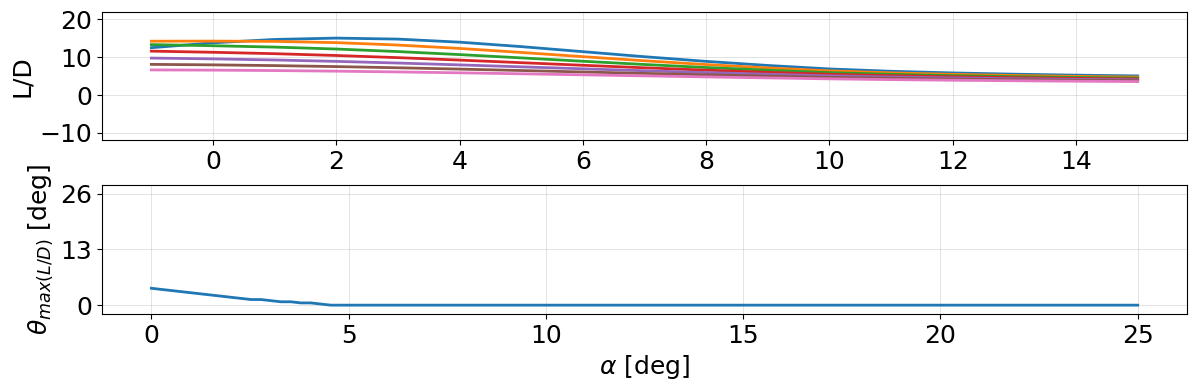

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(14,4))
plt.style.use('../utils/plot.mplstyle')

for i in np.arange(np.size(py.ac.aero['theta_flaps'])):
    ax[0].plot(py.ac.aero['alpha'][1:], py.ac.aero['c_l'][1:,i,0]/py.ac.aero['c_d'][1:,i,0])   
ax[0].set_ylabel('L/D')

ax[0].set_yticks([-10, 0, 10, 20])
ax[0].set_ylim([-12, 22])

ax[1].plot(alpha_lst, theta_best, '-')
ax[1].set_xlabel(r'$\alpha$ [deg]')
ax[1].set_ylabel(r'$\theta_{max(L/D)}$ [deg]')
ax[1].set_ylim([-2, 28])
ax[1].set_yticks([0, 13, 26])
ax[1].set_yticklabels([0, 13, 26])

plt.subplots_adjust(hspace=.35)

In [6]:
i = 0
plt.plot(py.ac.aero['alpha'], py.ac.aero['c_l'][:,i,10]/py.ac.aero['c_d'][:,i,10])   
i = 5
plt.plot(py.ac.aero['alpha'], py.ac.aero['c_l'][:,i,10]/py.ac.aero['c_d'][:,i,10])   

IndexError: index 10 is out of bounds for axis 2 with size 7

In [ ]:
Vclimb = np.linspace(100, 130, 100)
alpha_lst = np.zeros(100)

for j, V in enumerate(Vclimb):
    
#     CLreq = (2 * 55000 * 9.81) / (1.183858 * 150.4 * V**2)
    CLreq = (2 * 55000 * 9.81*np.cos(2.433723010732429*np.pi/180)) / (1.12 * 150.4 * V**2)

    alpha_lst[j] = f_alpha(-6, 10, CLreq)

In [ ]:
plt.plot(Vclimb, alpha_lst)
plt.ylim([0, 26])
plt.plot([100, 130], [13.6, 13.6])
plt.plot([109, 109], [0, 26])